# Maze Experiment Introduction

In this notebook, we will be running the MDP_Model on the Maze problem. This 2D simulation builds on a `gym-maze` package that can be found here: https://github.com/MattChanTK/gym-maze. Before beginning this simulation, please be sure to install the relevant packages on the github **Installation** section (pygame and numpy are also required)!

## Demonstration

First, a quick demonstration about what the game is. Essentially, there is a robot (circle) that starts on the blue start-point, then keeps taking steps (either with a designated policy or randomly), until it reaches the end point. Here is a simulation to demonstrate:

In [2]:
# Load Libraries
import numpy as np
import pandas as pd
import math
import random
import gym
import gym_maze

In [2]:
# Initializing the gym environment for a maze
env = gym.make("maze-sample-5x5-v0")

# Running the maze
observation = env.reset()
for _ in range(1000):
    
    env.render()
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
      
    if done:
      observation = env.reset()
env.close()

pygame 2.0.0.dev10 (SDL 2.0.12, python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Goal

The goal on our end is to derive our dataset from the path that the robot takes. Every time it reaches a new coordinate, depending on whether the coordinate is the goal, the robot gets a "reward." With these datapoints, our algorithm should be able to learn an MDP to map out the optimal path through the maze!

## Dataset Creation

Loading relevant packages and functions - make sure to change the `sys.path.append` line with the relevant directory that contains the MDP Algorithm.

In [3]:
# Set Working Directory
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')
#sys.path.append('/Users/Amine/Dropbox (MIT)/Research/Opioids/Opioids Git/Algorithm/')

#from MDPtools import *
from model import MDP_model
from maze_functions import createSamples, opt_model_trajectory, opt_maze_trajectory, plot_paths
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features

Now selecting parameters: here, we decide how many times we want the robot to run through the maze (`N`), when we want to start a new run if the robot takes too long (`T_max`), and the maze that we want the robot to run through (`mazes[x]`, with x being a number from the dictionary).

`reseed`' is set to `True` if we want the robot to travel to a different location within each cell every time it moves, while `False` ensures that the robot will start at a certain place in the initial coordinate, but move to the exact same place in the next coordinate. 

`r` is a float between 0 and 1 indicating the randomness percentage. For instance, if `r = 1`, the robot will take steps in completely random directions 100% of the time, while if `r = 0.5`, it will take half of its steps in the optimal direction (gotten by solving the maze MDP), but the other half randomly. 

In [9]:
N = 50
T_max = 100
r = 0.4

# list of maze options to choose from:
mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

df = createSamples(N, T_max, mazes[2], r, reseed=True)
print(df)

pygame 2.0.0.dev10 (SDL 2.0.12, python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html
     ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER
0     0     0   0.402458  -0.687017      1 -0.011111           0
1     0     1   0.561715  -1.507527      3 -0.011111           3
2     0     2   0.087498  -1.423891      0 -0.011111           3
3     0     3   0.390176  -0.007043      3 -0.011111           0
4     0     4   0.028750  -0.228748      1 -0.011111           0
..   ..   ...        ...        ...    ...       ...         ...
370  49     2   0.195713  -0.081568      1 -0.011111           0
371  49     3   0.187716  -1.302344      1 -0.011111           3
372  49     4   0.899212  -2.022426      2 -0.011111           6
373  49     5   1.270319  -2.485294      2 -0.011111           7
374  49     6   2.837707  -2.911432   None  1.000000           8

[375 rows x 7 columns]


The resulting `FEATURE_0` and `FEATURE_1` are the `x` and `y` coordinates respectively, while `ACTION` corresponds to the (`N`, `S`, `W`, `E`) directions. `RISK` is a reward of `1` if the endstate goal is reached, otherwise it is a negative factor of the maze size for all other locations. The robot does not change cells if it hits a wall, but if `reseed = True`, it can still change locations within the same cell. 

Here, we can visualize an example path that we are feeding as data into our algorithm. Note that it is not clear at all that there are grids or walls! The algorithm will train on these `N` paths to attempt to find the optimal policy. 

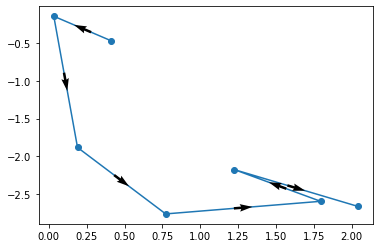

In [5]:
plot_paths(df, 1)

## Running the Algorithm

Now, we can run the algorithm on the generated dataset! First, we can set some parameters, including `max_k` which is the number of clusters we want to end with, and thus determines the number of iterations during the splitting process. Since initial clustering is based solely on `RISK`, and there are only two groups (end state and all others), there will only be two initial clusters. The expected optimal `max_k` should be the maze size. 

TODO: ADD AND EXPLAIN ETA

In [6]:
max_k = 9
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
actions = [0, 1, 2, 3]
gamma = 1
h = -1
cv = 5
th = 0
classification = 'DecisionTreeClassifier' 
split_classifier_params = {'random_state':0}

Now, we can fit an algorithm model to this, using either `m.fit` or `m.fit_CV` (this one runs with `cv` rounds of cross validation, and takes the optimal split). `m.fit` with `optimize=True` will train the model on all the data, and retain the model with an optimal amount of splits.

Splitting... |#Clusters:2:   0%|          | 0/7 [00:00<?, ?it/s]

Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION      RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.600147  -0.246111      1 -0.011111           0        0   
1     0     1   0.475737  -1.491138      1 -0.011111           3        0   
2     0     2   0.993525  -2.994561      2 -0.011111           6        0   
3     0     3   1.145446  -2.221433      2 -0.011111           7        0   
4     0     4   2.575629  -2.974348   None  1.000000           8        1   
..   ..   ...        ...        ...    ...       ...         ...      ...   
395  49     1   0.147698  -1.434768      1 -0.011111           3        0   
396  49     2   0.801475  -2.359333      2 -0.011111           6        0   
397  49     3   1.957382  -2.795158      0 -0.011111           7        0   
398  49     4   1.173551  -2.201315      2 -0.011111           7        0   
399  49     5   2.342438  -2.624912   None  1.000000           8        1   

    NEXT_CLUSTER  
0              0  
1              0

Splitting... |#Clusters:8:  86%|████████▌ | 6/7 [00:04<00:00,  1.45it/s]

Optimal # of clusters reached


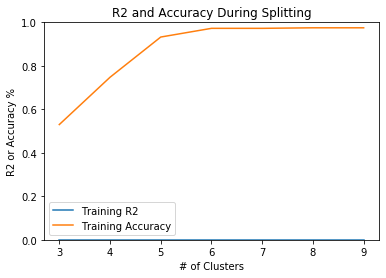

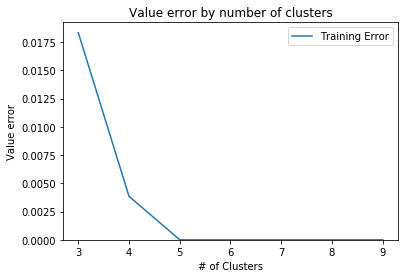

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [6]:
m = MDP_model()
m.fit(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    gamma, # discount factor
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    split_classifier_params, # classification parameters
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True,
    optimize=False)

## Visualizing Results

If `plot = True` above, you should see that the final Value error drops to close to 0 when the number of clusters is 9, which is what should be the case for a 3 by 3 maze! Here is another visualization of how the correct clusters should be:

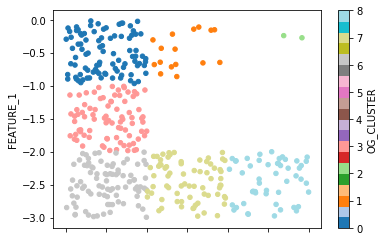

In [7]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='OG_CLUSTER')

And here is a visualization of how the algorithm currently views where the clusters are:

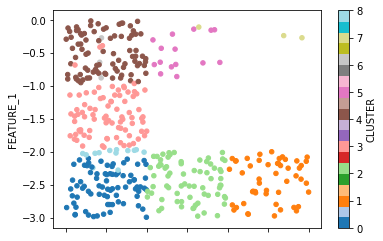

In [8]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', c='CLUSTER')

We can see that the clustering may not be completely perfect, and to quantify this, we can look at both the `training_error` and `purity`. The dataframe created by `training_error` tells us how the error was when we had that many clusters, so the error corresponding to `Clusters = 9` should be the lowest.

In [9]:
m.training_error

,Clusters,Error
0,3,1.832491e-02
1,4,3.849002e-03
2,5,1.143045e-16
3,6,1.005350e-16
4,7,1.005350e-16
5,8,9.678700e-17
6,9,9.550500e-17


The `purity` compares how much of the new clustering was made up of points from the same original cluster. We can see the percentage breakdown here - the higher the percentage, the better! 

In [10]:
purity(m.df_trained)

CLUSTER
0    1.000000
1    1.000000
2    1.000000
3    0.951220
4    1.000000
5    1.000000
6    1.000000
7    0.666667
8    0.615385
Name: Purity, dtype: float64

## Comparing Solutions

We can see how well our model learned the maze by comparing the optimal path it found to the real solution. The real solution is found by getting the actual transition and reward matrices of the maze, then solving this MDP to get the optimal policy. This is what the correct path should be:

Optimal Value: [8.79239362e-01 8.50543463e-01 8.22421483e-01 9.08520890e-01
 7.67853592e-01 7.94861942e-01 9.38400002e-01 9.68888890e-01
 1.00000000e+00 1.52126919e-09]
Optimal Policy: [1 3 3 1 2 0 2 2 0 0]


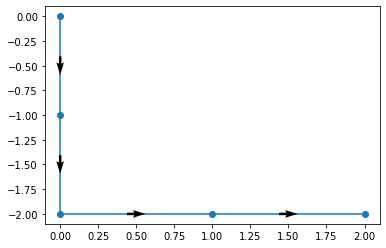

(array([0., 0., 0., 1., 2.]), array([-0., -1., -2., -2., -2.]))

In [11]:
opt_maze_trajectory(mazes[2])

And here, this is what our trained model found the solution to be (remember, our algorithm only got the messy data paths, and did not even know that there were 9 grid spaces!):

Optimal Value: [7.88888889e-01 1.00000000e+00 8.88888889e-01 6.98888889e-01
 6.17888889e-01 5.44988889e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.37442247e-10 0.00000000e+00]
Optimal Policy: [2 0 2 1 1 3 0 0 0 0 0]


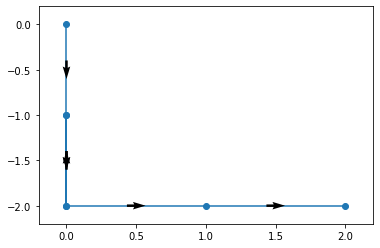

(array([0., 0., 0., 0., 0., 1., 2.]),
 array([-0., -1., -2., -1., -2., -2., -2.]))

In [12]:
opt_model_trajectory(m, mazes[2])

# Time for Bigger Mazes!

We can generate bigger mazes using the same method as above! Then, we will test to see if the optimal policy found by the maze is the same as the real optimal policy. 

#### Importing Modules

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import sys
sys.path.append('/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/')

from model import MDP_model
from maze_functions import createSamples, opt_maze_trajectory, opt_model_trajectory, policy_accuracy, \
    get_maze_transition_reward, plot_paths
from testing import cluster_size, next_clusters, training_value_error, purity, plot_features, testing_value_error

mazes = {1: 'maze-v0',
         2: 'maze-sample-3x3-v0',
         3: 'maze-random-3x3-v0',
         4: 'maze-sample-5x5-v0',
         5: 'maze-random-5x5-v0',
         6: 'maze-sample-10x10-v0',
         7: 'maze-random-10x10-v0',
         8: 'maze-sample-100x100-v0',
         9: 'maze-random-100x100-v0',
         10: 'maze-random-10x10-plus-v0', # has portals 
         11: 'maze-random-20x20-plus-v0', # has portals 
         12: 'maze-random-30x30-plus-v0'} # has portals 

#### Creating Samples

In [14]:
# Setting Parameters
N = 100
T_max = 25
r = 0.5
maze = mazes[4]

In [15]:
df = createSamples(N, T_max, maze, r, reseed=True)
df

,ID,TIME,FEATURE_0,FEATURE_1,ACTION,RISK,OG_CLUSTER
0,0,0,0.602988,-0.880256,1,-0.004,0
1,0,1,0.761949,-0.904760,2,-0.004,0
2,0,2,1.636787,-0.604966,2,-0.004,1
3,0,3,2.270172,-0.412354,1,-0.004,2
4,0,4,2.643965,-1.228215,1,-0.004,7
...,...,...,...,...,...,...,...
1773,74,14,4.630717,-0.561990,1,-0.004,4
1774,74,15,4.983835,-1.076496,1,-0.004,9
1775,74,16,4.089743,-2.586265,1,-0.004,14
1776,74,17,4.409917,-3.314069,1,-0.004,19


That's how the transition data looks like:

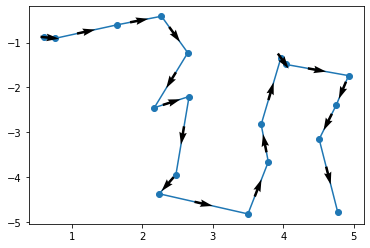

In [16]:
plot_paths(df,1)

Checking how many points actually reach the end: 

In [17]:
df.loc[df['ACTION']=='None']['ID'].count()

31

#### Fitting to Algorithm

Splitting... |#Clusters:2:   0%|          | 0/18 [00:00<?, ?it/s]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].uniqu

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:7:  28%|██▊       | 5/18 [00:12<00:34,  2.63s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: Fut

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/t

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Optimal # of clusters reached


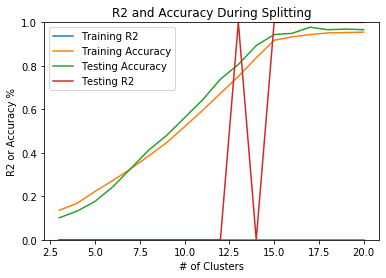

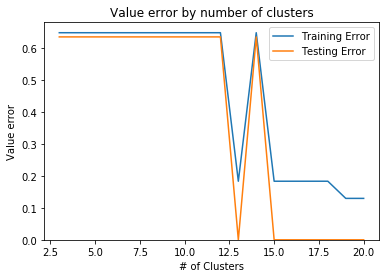

Splitting... |#Clusters:2:   0%|          | 0/18 [00:00<?, ?it/s]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].uniqu

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:7:  28%|██▊       | 5/18 [00:10<00:27,  2.10s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elemen

Splitting... |#Clusters:11:  50%|█████     | 9/18 [00:20<00:22,  2.50s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTE

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Optimal # of clusters reached


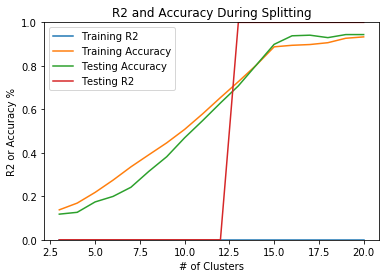

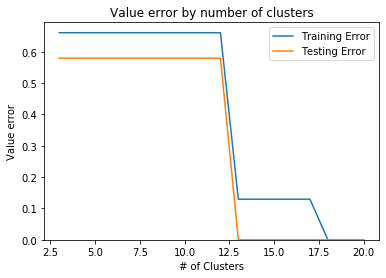

Splitting... |#Clusters:2:   0%|          | 0/18 [00:00<?, ?it/s]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].uniqu

Splitting... |#Clusters:7:  28%|██▊       | 5/18 [00:11<00:30,  2.35s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:12:  56%|█████▌    | 10/18 [00:26<00:24,  3.08s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: F

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Optimal # of clusters reached


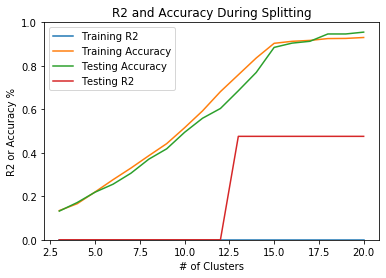

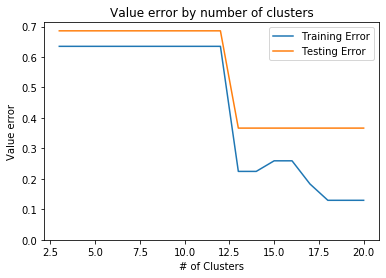

Splitting... |#Clusters:2:   0%|          | 0/18 [00:00<?, ?it/s]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].uniqu

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:7:  28%|██▊       | 5/18 [00:19<00:51,  3.97s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: Fut

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

Splitting... |#Clusters:16:  78%|███████▊  | 14/18 [00:53<00:14,  3.53s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

Optimal # of clusters reached


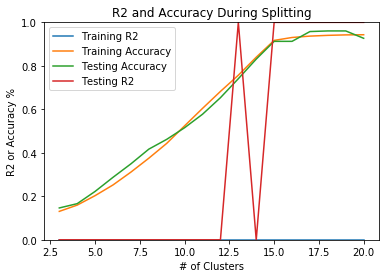

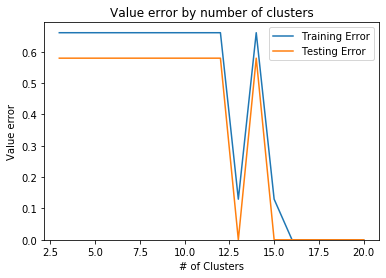

Splitting... |#Clusters:2:   0%|          | 0/18 [00:00<?, ?it/s]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].uniqu

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:7:  28%|██▊       | 5/18 [00:12<00:31,  2.43s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: Fut

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:12:  56%|█████▌    | 10/18 [00:21<00:15,  1.94s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: F

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:16:  78%|███████▊  | 14/18 [00:29<00:08,  2.01s/it]/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = test_clusters
Splitting... |#Clusters:18:  89%|████████▉ | 16/18 [00:36<00:05,  2.62s/it]

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():


/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:80: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'End' in P_df['NEXT_CLUSTER'].unique():
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['CLUSTER'] = model.predict(df_test.iloc[:, 2:2+pfeatures])
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:554: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

 17 taking action 2 , but this transition is never seen in the data. Data point: 0 22
Optimal # of clusters reached


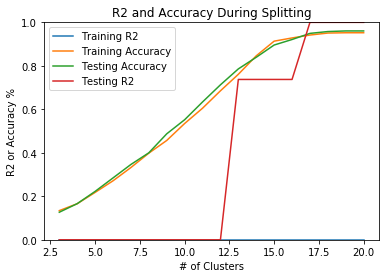

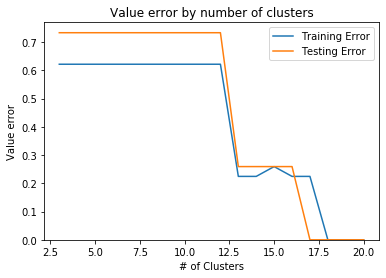

Splitting... |#Clusters:2:   0%|          | 0/15 [00:00<?, ?it/s]

best clusters: 17


Splitting... |#Clusters:16:  93%|█████████▎| 14/15 [00:29<00:02,  2.52s/it]

Splitting... |#Clusters:16:  93%|█████████▎| 14/15 [00:32<00:02,  2.33s/it]

Optimal # of clusters reached


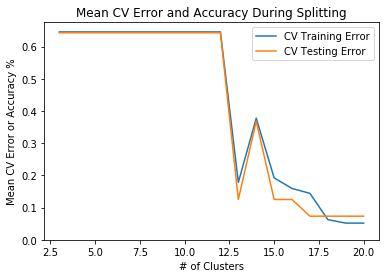

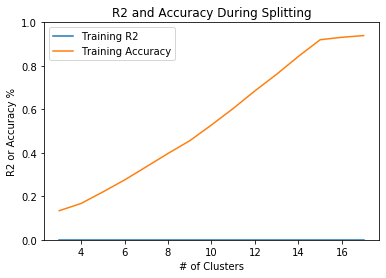

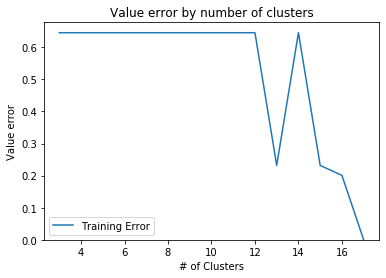

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [18]:
# Setting parameters for model fitting
max_k = 20
classification = 'DecisionTreeClassifier'
split_classifier_params = {'random_state':0, 'max_depth':2}
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0

m = MDP_model()
m.fit_CV(df, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
    pfeatures, # int: number of features
    h, # int: time horizon (# of actions we want to optimize)
    gamma, # discount factor
    max_k, # int: number of iterations
    distance_threshold, # clustering diameter for Agglomerative clustering
    cv, # number for cross validation
    th, # splitting threshold
    classification, # classification method
    split_classifier_params, # classifier params
    clustering,# clustering method from Agglomerative, KMeans, and Birch
    n_clusters, # number of clusters for KMeans
    random_state,
    plot=True)#,
    #optimize=False)

#### Observing Policies

First, let's see what the clustering that the model found actually looks like!

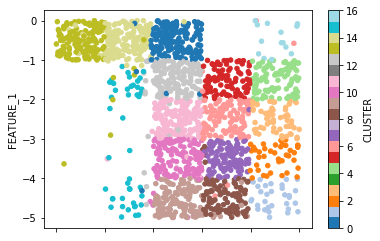

In [19]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'CLUSTER')

And compare it with a clustering with the actual cells of the Maze.

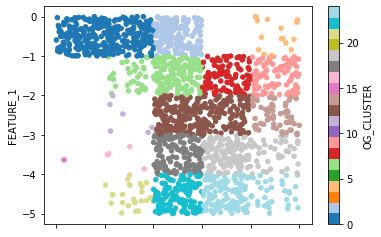

In [20]:
plot_features(m.df_trained, 'FEATURE_0', 'FEATURE_1', 'OG_CLUSTER')

In [49]:
def plot_features(df, x, y, c='CLUSTER'):
    df.plot.scatter(x=x,
                      y=y,
                      c=c,
                      colormap='tab20')
#    import seaborn as sns
#    sns.pairplot(x_vars=["FEATURE_1"], y_vars=["FEATURE_2"], data=df, hue="OG_CLUSTER", height=5)
    plt.show()

Now, let's see what the optimal policy our model learns is:

Optimal Value: [2.53726718e-01 1.00000000e+00 8.96000000e-01 8.02400000e-01
 7.18160000e-01 6.42344000e-01 5.74109600e-01 5.12698640e-01
 4.57428776e-01 4.07685899e-01 3.62917309e-01 3.22625578e-01
 2.86363020e-01 1.97918642e-01 2.24354046e-01 3.62917309e-01
 0.00000000e+00 1.99256272e-10 0.00000000e+00]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0]


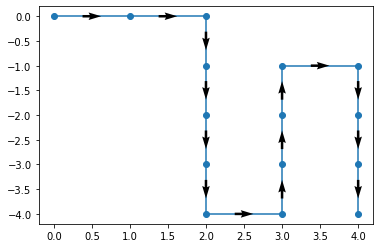

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [28]:
opt_model_trajectory(m, maze, 5, 0.7)

And here is an actual simulation of a point through the maze by taking the found optimal policy. Note that we have set a sink node as the bottom left corner, which is where the path will go once it has reached the goal state.

/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/testing.py:495: RuntimeWarning: invalid value encountered in true_divide
  ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid")


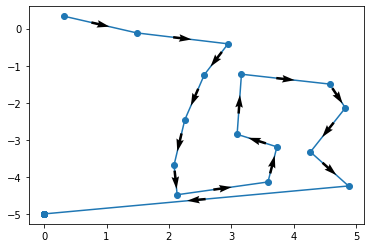

(array([0.32074064, 1.48529804, 2.94897357, 2.56862557, 2.25516784,
        2.08292424, 2.13328836, 3.58955931, 3.73337227, 3.0947517 ,
        3.1642547 , 4.5781614 , 4.83070406, 4.27055124, 4.88163089,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([ 0.3345083 , -0.1151754 , -0.40999199, -1.24441575, -2.46204194,
        -3.6825478 , -4.48259297, -4.13766013, -3.19019461, -2.85156114,
        -1.2297999 , -1.49584137, -2.13839492, -3.32758127, -4.24552431,
        -5.        , -5.        , -5.        , -5.        , -5.        ,
        -5.        , -5.        , -5.        , -5.        , -5.        ,
        -5.        , -5.        , -5.        , -5.        , -5.        ,
        -5.        ]))

In [30]:
f, r = get_maze_transition_reward(maze)
x0= np.random.rand(2)
m.opt_model_trajectory(x0, f)

Going through each point in the training data set, here is how many (by percentage) our optimal policy actually returned the correct action for. This is essentially the training accuracy:

In [31]:
policy_accuracy(m, maze)

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


0.953880764904387

Now, we will generate a new unseen test set using optimal parameters, and see how well the model does. This is the testing accuracy. 

In [33]:
df_test = createSamples(50, T_max, maze, 0.3, reseed=True)
testing_value_error(df_test, m.df_trained, m.m, m.pfeatures, relative=False, h=-1)

3.3993498887762957e-18

Here is a metric that measures how good our classification model is in putting points in the right cluster:

In [34]:
m.clus_pred_accuracy

0.9746906636670416

And finally, here is the optimal policy for reference:

Optimal Value: [7.04370331e-01 7.22826868e-01 7.41660069e-01 8.84704957e-01
 9.06841793e-01 6.51186120e-01 7.04370331e-01 7.60877622e-01
 9.06841793e-01 9.29430401e-01 6.68557266e-01 6.86282924e-01
 7.80487369e-01 8.84704957e-01 9.52480001e-01 7.60877622e-01
 7.80487369e-01 8.00497316e-01 8.63010858e-01 9.76000001e-01
 7.41660069e-01 8.00497316e-01 8.20915628e-01 8.41750641e-01
 1.00000000e+00 9.55885364e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]


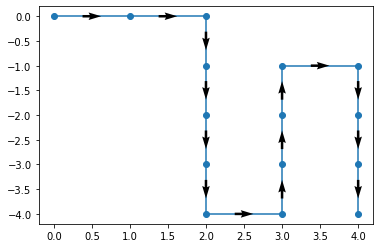

(array([0., 1., 2., 2., 2., 2., 2., 3., 3., 3., 3., 4., 4., 4., 4.]),
 array([-0.,  0.,  0., -1., -2., -3., -4., -4., -3., -2., -1., -1., -2.,
        -3., -4.]))

In [35]:
opt_maze_trajectory(maze)

## Model Performance Based On Data Size

Now that we've seen how one model can perform based on one generated dataset, let's see how the model performs when given different numbers of paths to learn from. We will use a pre-generated dataset for a 5x5 maze with 200 paths, with parameters of `randomness = 0.4`, and `T_max = 25` (maximum number of steps). 

In [4]:
# Loading and preparing the dataset
# UPDATE with path and filename for dataset you want to use!
path = '/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids_Dropbox/Maze/fitted_Q Comparisons/Datasets/Test 1 (N=200, T_max = 25, randomness=0.4)'
sys.path.append(path)
filename = 'set_4.csv'
df = pd.read_csv(path+'/'+filename)

# taking out extra ID col and changing actions back to integers
df = df.iloc[:, 1:]
df.loc[df['ACTION']=='None', 'ACTION'] = 4
df['ACTION'] = pd.to_numeric(df['ACTION'], downcast='integer')
df.loc[df['ACTION']==4, 'ACTION'] = 'None'

df

,ID,TIME,FEATURE_0,FEATURE_1,ACTION,RISK,OG_CLUSTER
0,0,0,0.917504,-0.359175,2,-0.004,0
1,0,1,1.469175,-0.730709,2,-0.004,1
2,0,2,2.663953,-0.227007,1,-0.004,2
3,0,3,2.141935,-1.350262,1,-0.004,7
4,0,4,2.644228,-2.347577,0,-0.004,12
...,...,...,...,...,...,...,...
4568,199,14,3.757846,-1.040545,2,-0.004,8
4569,199,15,4.219758,-1.602285,1,-0.004,9
4570,199,16,4.444872,-2.464416,1,-0.004,14
4571,199,17,4.219659,-3.406585,1,-0.004,19


Now, we want to see how well the model trains on different subsets of the data, starting with when it only has access to the first 10 paths, `N=10`, all the way to all 200 paths, `N=200`. The subsets we look at can be seen in the list `Ns`. 

We will train a separate model for each data-size, then plot some trends in how the algorithm learns as training data increases.

Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.917504  -0.359175      2 -0.004           0        0   
1     0     1   1.469175  -0.730709      2 -0.004           1        0   
2     0     2   2.663953  -0.227007      1 -0.004           2        0   
3     0     3   2.141935  -1.350262      1 -0.004           7        0   
4     0     4   2.644228  -2.347577      0 -0.004          12        0   
..   ..   ...        ...        ...    ...    ...         ...      ...   
226   9    18   4.881530  -2.888142      1 -0.004          14        0   
227   9    19   4.515281  -3.187259      0 -0.004          19        0   
228   9    20   4.994324  -2.549241      1 -0.004          14        0   
229   9    21   4.440553  -3.575720      1 -0.004          19        0   
230   9    22   4.064881  -4.855516   None  1.000          24        1   

    NEXT_CLUSTER  
0              0  
1              0  
2              0  
3             

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:00<00:17,  1.29it/s]

threshold 30.397368307141324 max_inc 8.000000000000002
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:01<00:13,  1.52it/s]

threshold 22.798026230355994 max_inc 8.0


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:01<00:11,  1.82it/s]

threshold 18.238420984284794 max_inc 10.999999999999996


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:01<00:09,  2.10it/s]

threshold 15.198684153570662 max_inc 8.000000000000002


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:02<00:07,  2.40it/s]

threshold 13.027443560203425 max_inc 12.999999999999998


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:02<00:06,  2.62it/s]

threshold 11.399013115177997 max_inc 12.000000000000002


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:02<00:05,  2.79it/s]

threshold 10.132456102380441 max_inc 11.0


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:02<00:05,  2.92it/s]

threshold 9.119210492142397 max_inc 11.999999999999996


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:03<00:05,  2.47it/s]

threshold 8.29019135649309 max_inc 10.999999999999998


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:03<00:05,  2.33it/s]

threshold 7.599342076785331 max_inc 13.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:04<00:05,  2.29it/s]

threshold 7.014777301647998 max_inc 5.0
new opt_k 13


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:04<00:04,  2.28it/s]

threshold 6.513721780101712 max_inc 13.000000000000002


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:05<00:04,  2.22it/s]

threshold 6.079473661428265 max_inc 5.0


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:05<00:04,  2.13it/s]

threshold 5.6995065575889985 max_inc 3.0


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:06<00:03,  2.03it/s]

threshold 5.364241465966116 max_inc 3.0000000000000004


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:06<00:03,  1.97it/s]

threshold 5.066228051190221 max_inc 4.0


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:07<00:03,  1.94it/s]

threshold 4.7995844695486305 max_inc 4.0


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:08<00:02,  1.90it/s]

threshold 4.559605246071198 max_inc 5.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:08<00:02,  1.89it/s]

threshold 4.342481186734475 max_inc 4.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:09<00:01,  1.86it/s]

threshold 4.145095678246545 max_inc 5.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:09<00:01,  1.80it/s]

threshold 3.9648741270184336 max_inc 4.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:10<00:00,  1.75it/s]

threshold 3.7996710383926655 max_inc 7.000000000000001


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:10<00:00,  2.00it/s]

threshold 3.647684196856959 max_inc 4.0
Optimal # of clusters reached


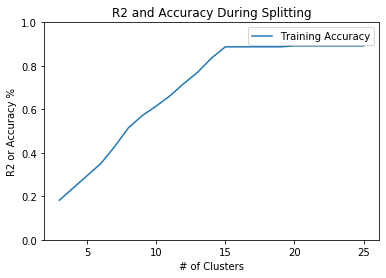

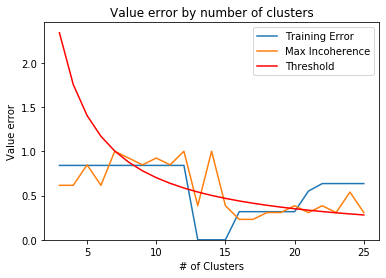

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 10  completed
Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.917504  -0.359175      2 -0.004           0        0   
1     0     1   1.469175  -0.730709      2 -0.004           1        0   
2     0     2   2.663953  -0.227007      1 -0.004           2        0   
3     0     3   2.141935  -1.350262      1 -0.004           7        0   
4     0     4   2.644228  -2.347577      0 -0.004          12        0   
..   ..   ...        ...        ...    ...    ...         ...      ...   
449  19    16   3.939028  -1.895875      2 -0.004           8        0   
450  19    17   4.155241  -1.670404      1 -0.004           9        0   
451  19    18   4.580430  -2.045098      1 -0.004          14        0   
452  19    19   4.196528  -3.134922      1 -0.004          19        0   
453  19    20   4.995242  -4.934154   None  1.000          24        1   

    NEXT_CLUSTER  
0              0  
1              0  
2              0

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:00<00:09,  2.44it/s]

threshold 42.61455150532503 max_inc 17.99999999999999
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:00<00:08,  2.38it/s]

threshold 31.960913628993772 max_inc 18.000000000000004


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:01<00:08,  2.33it/s]

threshold 25.568730903195018 max_inc 25.999999999999996


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:01<00:08,  2.21it/s]

threshold 21.307275752662516 max_inc 21.999999999999993


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:02<00:08,  2.10it/s]

threshold 18.26337921656787 max_inc 26.000000000000007


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:03<00:09,  1.82it/s]

threshold 15.980456814496886 max_inc 24.000000000000004


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:03<00:09,  1.71it/s]

threshold 14.20485050177501 max_inc 23.000000000000007


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:04<00:09,  1.53it/s]

threshold 12.784365451597509 max_inc 24.999999999999993


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:05<00:10,  1.37it/s]

threshold 11.62215041054319 max_inc 23.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:06<00:09,  1.34it/s]

threshold 10.653637876331258 max_inc 22.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:07<00:09,  1.28it/s]

threshold 9.834127270459621 max_inc 6.0
new opt_k 13


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:08<00:09,  1.19it/s]

threshold 9.131689608283935 max_inc 7.000000000000001


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:09<00:08,  1.13it/s]

threshold 8.522910301065005 max_inc 6.0


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:09<00:08,  1.12it/s]

threshold 7.990228407248443 max_inc 6.0


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:10<00:07,  1.12it/s]

threshold 7.520214971527946 max_inc 6.0


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:11<00:06,  1.08it/s]

threshold 7.102425250887505 max_inc 6.0


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:12<00:05,  1.07it/s]

threshold 6.728613395577637 max_inc 11.0


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:13<00:04,  1.07it/s]

threshold 6.3921827257987545 max_inc 12.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:14<00:03,  1.04it/s]

threshold 6.08779307218929 max_inc 9.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:15<00:02,  1.04it/s]

threshold 5.811075205271595 max_inc 8.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:16<00:01,  1.03it/s]

threshold 5.558419761564134 max_inc 10.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:17<00:01,  1.00s/it]

threshold 5.326818938165629 max_inc 13.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:19<00:00,  1.15it/s]

threshold 5.113746180639003 max_inc 8.0
Optimal # of clusters reached


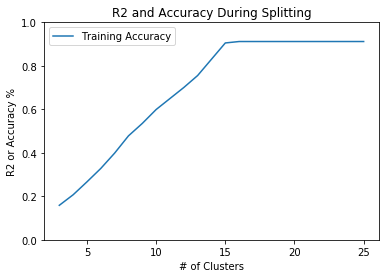

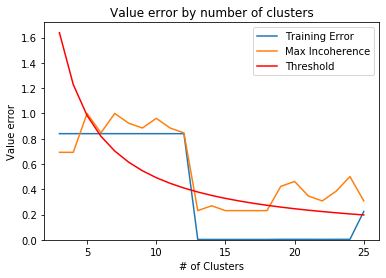

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 20  completed
Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.917504  -0.359175      2 -0.004           0        0   
1     0     1   1.469175  -0.730709      2 -0.004           1        0   
2     0     2   2.663953  -0.227007      1 -0.004           2        0   
3     0     3   2.141935  -1.350262      1 -0.004           7        0   
4     0     4   2.644228  -2.347577      0 -0.004          12        0   
..   ..   ...        ...        ...    ...    ...         ...      ...   
674  29    20   4.013413  -1.851803      1 -0.004           9        0   
675  29    21   4.815683  -2.942802      3 -0.004          14        0   
676  29    22   4.988388  -2.226254      1 -0.004          14        0   
677  29    23   4.879619  -3.543273      1 -0.004          19        0   
678  29    24   4.022006  -4.380492   None  1.000          24        1   

    NEXT_CLUSTER  
0              0  
1              0  
2              0

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:00<00:12,  1.74it/s]

threshold 52.11525688318153 max_inc 25.000000000000007
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:01<00:12,  1.70it/s]

threshold 39.08644266238615 max_inc 30.000000000000014


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:01<00:12,  1.66it/s]

threshold 31.26915412990892 max_inc 40.999999999999986


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:02<00:12,  1.54it/s]

threshold 26.057628441590765 max_inc 35.0


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:03<00:12,  1.45it/s]

threshold 22.335110092792085 max_inc 39.00000000000001


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:04<00:12,  1.32it/s]

threshold 19.543221331193074 max_inc 33.99999999999999


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:05<00:13,  1.22it/s]

threshold 17.371752294393843 max_inc 36.00000000000001


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:06<00:13,  1.13it/s]

threshold 15.63457706495446 max_inc 39.00000000000001


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:07<00:12,  1.08it/s]

threshold 14.213251877231327 max_inc 38.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:08<00:12,  1.01it/s]

threshold 13.028814220795383 max_inc 38.00000000000001


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:09<00:12,  1.08s/it]

threshold 12.02659774227266 max_inc 19.0


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:11<00:15,  1.39s/it]

threshold 11.167555046396043 max_inc 41.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:13<00:15,  1.51s/it]

threshold 10.423051376636305 max_inc 15.0


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:15<00:13,  1.54s/it]

threshold 9.771610665596537 max_inc 15.0


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:16<00:11,  1.46s/it]

threshold 9.196810038208506 max_inc 7.0
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:17<00:09,  1.40s/it]

threshold 8.685876147196922 max_inc 7.0


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:19<00:08,  1.35s/it]

threshold 8.228724771028663 max_inc 7.0


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:20<00:06,  1.33s/it]

threshold 7.81728853247723 max_inc 7.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:21<00:05,  1.31s/it]

threshold 7.445036697597361 max_inc 7.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:23<00:04,  1.48s/it]

threshold 7.106625938615664 max_inc 7.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:25<00:03,  1.50s/it]

threshold 6.797642202154113 max_inc 10.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:26<00:01,  1.58s/it]

threshold 6.514407110397691 max_inc 13.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:28<00:01,  1.29s/it]

threshold 6.253830825981783 max_inc 12.0
Optimal # of clusters reached


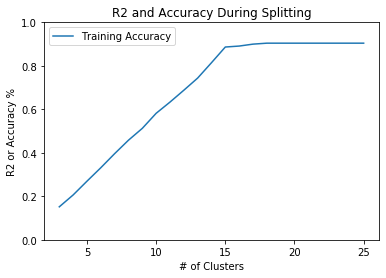

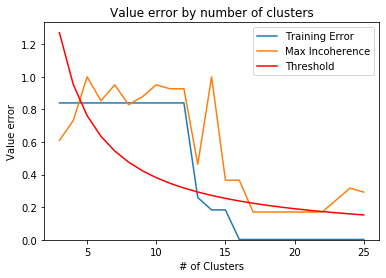

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 30  completed
Clusters Initialized
     ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0     0     0   0.917504  -0.359175      2 -0.004           0        0   
1     0     1   1.469175  -0.730709      2 -0.004           1        0   
2     0     2   2.663953  -0.227007      1 -0.004           2        0   
3     0     3   2.141935  -1.350262      1 -0.004           7        0   
4     0     4   2.644228  -2.347577      0 -0.004          12        0   
..   ..   ...        ...        ...    ...    ...         ...      ...   
912  39    20   4.880932  -1.307037      2 -0.004           9        0   
913  39    21   4.619737  -1.689840      1 -0.004           9        0   
914  39    22   4.459208  -2.826541      1 -0.004          14        0   
915  39    23   4.106037  -3.890418      1 -0.004          19        0   
916  39    24   4.571552  -4.986491   None  1.000          24        1   

    NEXT_CLUSTER  
0              0  
1              0  
2              0

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:00<00:14,  1.50it/s]

threshold 60.56401571890688 max_inc 31.0
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:01<00:14,  1.45it/s]

threshold 45.42301178918016 max_inc 36.0


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:02<00:14,  1.39it/s]

threshold 36.338409431344125 max_inc 51.000000000000014


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:03<00:14,  1.31it/s]

threshold 30.28200785945344 max_inc 48.999999999999986


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:03<00:14,  1.23it/s]

threshold 25.956006736674375 max_inc 48.000000000000014


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:04<00:14,  1.16it/s]

threshold 22.71150589459008 max_inc 45.0


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:05<00:14,  1.11it/s]

threshold 20.188005239635626 max_inc 43.00000000000001


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:07<00:15,  1.03s/it]

threshold 18.169204715672063 max_inc 52.99999999999999


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:08<00:15,  1.12s/it]

threshold 16.51745883242915 max_inc 48.00000000000001


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:09<00:15,  1.16s/it]

threshold 15.14100392972672 max_inc 50.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:11<00:14,  1.17s/it]

threshold 13.97631131974774 max_inc 26.0


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:12<00:12,  1.18s/it]

threshold 12.978003368337188 max_inc 56.00000000000001


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:13<00:11,  1.20s/it]

threshold 12.112803143781376 max_inc 10.999999999999998
new opt_k 15


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:15<00:11,  1.29s/it]

threshold 11.35575294729504 max_inc 10.999999999999998
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:16<00:10,  1.37s/it]

threshold 10.687767479807096 max_inc 8.000000000000002
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:17<00:09,  1.38s/it]

threshold 10.094002619817813 max_inc 8.000000000000002


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:19<00:08,  1.37s/it]

threshold 9.562739324037928 max_inc 8.000000000000002


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:20<00:07,  1.41s/it]

threshold 9.084602357836031 max_inc 9.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:22<00:05,  1.44s/it]

threshold 8.652002245558126 max_inc 12.000000000000002


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:23<00:04,  1.47s/it]

threshold 8.258729416214575 max_inc 10.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:25<00:02,  1.47s/it]

threshold 7.8996542242052445 max_inc 10.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:26<00:01,  1.47s/it]

threshold 7.57050196486336 max_inc 8.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:28<00:01,  1.29s/it]

threshold 7.267681886268825 max_inc 8.0
Optimal # of clusters reached


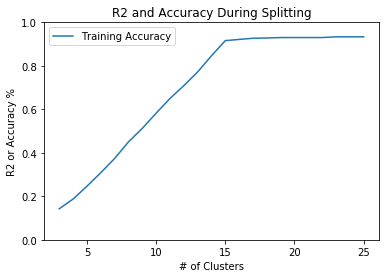

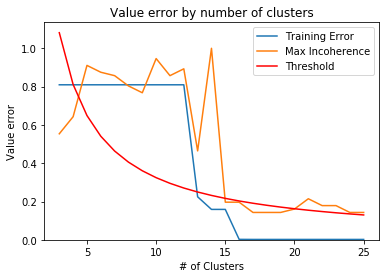

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 40  completed
Clusters Initialized
      ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0      0     0   0.917504  -0.359175      2 -0.004           0        0   
1      0     1   1.469175  -0.730709      2 -0.004           1        0   
2      0     2   2.663953  -0.227007      1 -0.004           2        0   
3      0     3   2.141935  -1.350262      1 -0.004           7        0   
4      0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ..   ...        ...        ...    ...    ...         ...      ...   
1155  49    20   4.365331  -1.573990      3 -0.004           9        0   
1156  49    21   3.630374  -1.646157      2 -0.004           8        0   
1157  49    22   4.114909  -1.347248      2 -0.004           9        0   
1158  49    23   4.527278  -1.976064      1 -0.004           9        0   
1159  49    24   4.472134  -2.835000      1 -0.004          14        0   

     NEXT_CLUSTER  
0               0  
1               0  
2

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:01<00:26,  1.22s/it]

threshold 68.11754546370561 max_inc 33.999999999999986
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:02<00:24,  1.17s/it]

threshold 51.08815909777921 max_inc 42.0


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:03<00:22,  1.15s/it]

threshold 40.87052727822337 max_inc 62.999999999999986


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:04<00:24,  1.26s/it]

threshold 34.058772731852805 max_inc 58.00000000000002


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:06<00:22,  1.27s/it]

threshold 29.193233770159548 max_inc 61.0


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:08<00:24,  1.45s/it]

threshold 25.544079548889606 max_inc 56.0


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:09<00:24,  1.55s/it]

threshold 22.70584848790187 max_inc 56.99999999999999


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:11<00:23,  1.58s/it]

threshold 20.435263639111685 max_inc 68.0


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:13<00:22,  1.58s/it]

threshold 18.57751239919244 max_inc 61.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:14<00:20,  1.57s/it]

threshold 17.029386365926403 max_inc 65.00000000000001


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:16<00:18,  1.52s/it]

threshold 15.71943356854745 max_inc 30.000000000000004


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:17<00:16,  1.50s/it]

threshold 14.596616885079774 max_inc 67.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:19<00:16,  1.70s/it]

threshold 13.623509092741124 max_inc 11.0
new opt_k 15


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:22<00:17,  1.90s/it]

threshold 12.772039774444803 max_inc 10.0
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:24<00:15,  1.98s/it]

threshold 12.02074331712452 max_inc 10.0
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:27<00:16,  2.32s/it]

threshold 11.352924243950936 max_inc 10.0


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:29<00:14,  2.39s/it]

threshold 10.75540191532194 max_inc 10.0


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:32<00:12,  2.46s/it]

threshold 10.217631819555843 max_inc 26.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:34<00:08,  2.24s/it]

threshold 9.731077923386517 max_inc 22.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:35<00:06,  2.08s/it]

threshold 9.28875619959622 max_inc 21.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:37<00:03,  1.95s/it]

threshold 8.884897234396385 max_inc 22.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:39<00:01,  1.97s/it]

threshold 8.514693182963201 max_inc 23.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:41<00:01,  1.90s/it]

threshold 8.174105455644673 max_inc 27.0
Optimal # of clusters reached


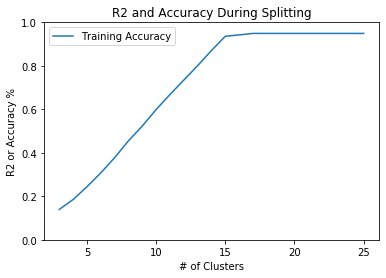

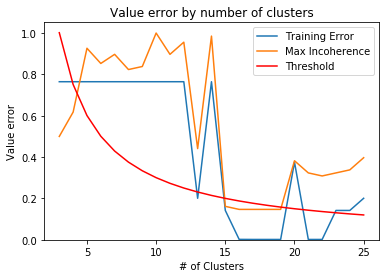

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 50  completed
Clusters Initialized
      ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0      0     0   0.917504  -0.359175      2 -0.004           0        0   
1      0     1   1.469175  -0.730709      2 -0.004           1        0   
2      0     2   2.663953  -0.227007      1 -0.004           2        0   
3      0     3   2.141935  -1.350262      1 -0.004           7        0   
4      0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ..   ...        ...        ...    ...    ...         ...      ...   
1603  69    18   4.224119  -1.117528      1 -0.004           9        0   
1604  69    19   4.852512  -2.929003      1 -0.004          14        0   
1605  69    20   4.836845  -3.102088      3 -0.004          19        0   
1606  69    21   4.732959  -3.151802      1 -0.004          19        0   
1607  69    22   4.967610  -4.635525   None  1.000          24        1   

     NEXT_CLUSTER  
0               0  
1               0  
2

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:01<00:28,  1.29s/it]

threshold 80.19975062305369 max_inc 47.000000000000014
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:03<00:30,  1.44s/it]

threshold 60.149812967290266 max_inc 61.00000000000001


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:04<00:29,  1.46s/it]

threshold 48.119850373832215 max_inc 80.99999999999996


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:06<00:28,  1.51s/it]

threshold 40.099875311526844 max_inc 79.0


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:07<00:28,  1.56s/it]

threshold 34.37132169559444 max_inc 85.0


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:09<00:27,  1.60s/it]

threshold 30.074906483645133 max_inc 82.00000000000001


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:11<00:25,  1.62s/it]

threshold 26.733250207684563 max_inc 79.0


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:13<00:25,  1.69s/it]

threshold 24.059925186916107 max_inc 97.99999999999997


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:14<00:24,  1.72s/it]

threshold 21.872659260832823 max_inc 89.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:17<00:25,  1.95s/it]

threshold 20.049937655763422 max_inc 90.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:19<00:24,  2.01s/it]

threshold 18.507634759166237 max_inc 38.0


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:21<00:21,  1.98s/it]

threshold 17.18566084779722 max_inc 94.00000000000001


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:23<00:21,  2.12s/it]

threshold 16.039950124610737 max_inc 18.999999999999996


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:25<00:18,  2.09s/it]

threshold 15.037453241822567 max_inc 15.000000000000002
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:27<00:16,  2.03s/it]

threshold 14.15289716877418 max_inc 7.000000000000001
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:29<00:13,  1.99s/it]

threshold 13.366625103842281 max_inc 7.000000000000001


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:31<00:11,  1.95s/it]

threshold 12.66311851942953 max_inc 13.000000000000002


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:33<00:09,  1.98s/it]

threshold 12.029962593458054 max_inc 9.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:35<00:07,  1.99s/it]

threshold 11.457107231864812 max_inc 7.000000000000001


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:37<00:05,  1.97s/it]

threshold 10.936329630416411 max_inc 7.000000000000001


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:40<00:04,  2.32s/it]

threshold 10.460837037789611 max_inc 6.9999999999999964


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:42<00:02,  2.27s/it]

threshold 10.024968827881711 max_inc 6.9999999999999964


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:45<00:02,  2.06s/it]

threshold 9.623970074766442 max_inc 13.000000000000004
Optimal # of clusters reached


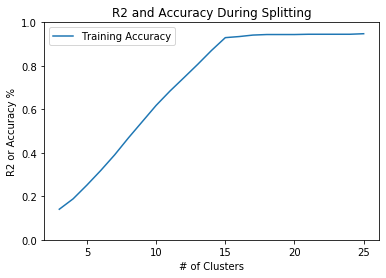

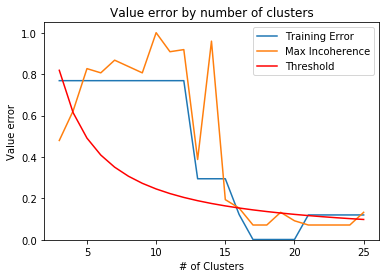

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 70  completed
Clusters Initialized
      ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0      0     0   0.917504  -0.359175      2 -0.004           0        0   
1      0     1   1.469175  -0.730709      2 -0.004           1        0   
2      0     2   2.663953  -0.227007      1 -0.004           2        0   
3      0     3   2.141935  -1.350262      1 -0.004           7        0   
4      0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ..   ...        ...        ...    ...    ...         ...      ...   
2067  89    20   3.941743  -2.325762      1 -0.004          13        0   
2068  89    21   3.818936  -3.117755      0 -0.004          18        0   
2069  89    22   3.793701  -2.730175      0 -0.004          13        0   
2070  89    23   3.776642  -1.817984      0 -0.004           8        0   
2071  89    24   3.774145  -1.747858      0 -0.004           8        0   

     NEXT_CLUSTER  
0               0  
1               0  
2

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:01<00:34,  1.58s/it]

threshold 91.03845341392834 max_inc 70.99999999999999
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:03<00:34,  1.63s/it]

threshold 68.27884006044626 max_inc 85.00000000000003


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:05<00:33,  1.69s/it]

threshold 54.623072048357 max_inc 107.99999999999999


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:07<00:34,  1.80s/it]

threshold 45.51922670696417 max_inc 105.99999999999997


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:09<00:37,  2.08s/it]

threshold 39.01648003454072 max_inc 110.99999999999999


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:11<00:34,  2.04s/it]

threshold 34.13942003022313 max_inc 105.00000000000001


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:14<00:33,  2.12s/it]

threshold 30.346151137976115 max_inc 102.00000000000001


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:15<00:29,  1.98s/it]

threshold 27.3115360241785 max_inc 122.00000000000001


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:17<00:28,  2.02s/it]

threshold 24.828669112889546 max_inc 111.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:21<00:30,  2.33s/it]

threshold 22.759613353482084 max_inc 111.99999999999997


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:24<00:30,  2.57s/it]

threshold 21.008873864752694 max_inc 48.0


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:26<00:27,  2.54s/it]

threshold 19.50824001727036 max_inc 119.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:29<00:25,  2.55s/it]

threshold 18.207690682785667 max_inc 29.999999999999993


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:31<00:21,  2.44s/it]

threshold 17.069710015111564 max_inc 29.999999999999993


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:33<00:18,  2.35s/it]

threshold 16.065609425987354 max_inc 10.0
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:35<00:15,  2.27s/it]

threshold 15.173075568988057 max_inc 6.999999999999999


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:37<00:13,  2.21s/it]

threshold 14.374492644304475 max_inc 23.0


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:39<00:10,  2.20s/it]

threshold 13.65576801208925 max_inc 15.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:42<00:08,  2.20s/it]

threshold 13.005493344846906 max_inc 9.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:44<00:06,  2.20s/it]

threshold 12.414334556444773 max_inc 11.999999999999996


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:46<00:04,  2.23s/it]

threshold 11.87458088007761 max_inc 9.000000000000002


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:48<00:02,  2.23s/it]

threshold 11.379806676741042 max_inc 9.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:50<00:02,  2.32s/it]

threshold 10.9246144096714 max_inc 27.0
Optimal # of clusters reached


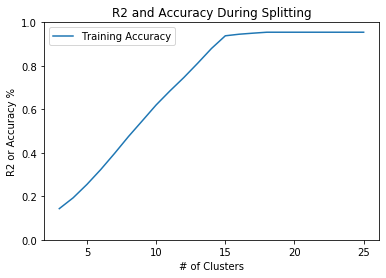

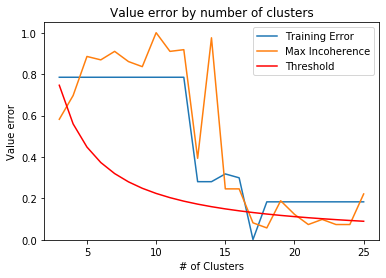

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 90  completed
Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.917504  -0.359175      2 -0.004           0        0   
1       0     1   1.469175  -0.730709      2 -0.004           1        0   
2       0     2   2.663953  -0.227007      1 -0.004           2        0   
3       0     3   2.141935  -1.350262      1 -0.004           7        0   
4       0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
2518  109    18   3.420509  -1.279941      2 -0.004           8        0   
2519  109    19   4.685916  -1.862156      1 -0.004           9        0   
2520  109    20   4.937795  -2.040531      1 -0.004          14        0   
2521  109    21   4.205817  -3.535563      1 -0.004          19        0   
2522  109    22   4.377387  -4.853242   None  1.000          24        1   

     NEXT_CLUSTER  
0               0  
1        

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:01<00:42,  1.95s/it]

threshold 100.45894683899489 max_inc 92.00000000000003
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:04<00:43,  2.08s/it]

threshold 75.34421012924616 max_inc 105.0


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:06<00:41,  2.09s/it]

threshold 60.27536810339693 max_inc 129.00000000000003


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:08<00:38,  2.05s/it]

threshold 50.229473419497445 max_inc 124.99999999999997


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:10<00:37,  2.06s/it]

threshold 43.05383435956924 max_inc 133.00000000000003


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:12<00:36,  2.16s/it]

threshold 37.67210506462308 max_inc 128.00000000000003


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:15<00:35,  2.23s/it]

threshold 33.4863156129983 max_inc 122.00000000000001


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:17<00:33,  2.22s/it]

threshold 30.137684051698464 max_inc 153.00000000000003


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:19<00:30,  2.18s/it]

threshold 27.397894592453152 max_inc 144.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:21<00:28,  2.20s/it]

threshold 25.114736709748723 max_inc 143.00000000000003


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:24<00:27,  2.27s/it]

threshold 23.182833885921898 max_inc 55.99999999999999


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:26<00:25,  2.34s/it]

threshold 21.52691717978462 max_inc 149.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:30<00:27,  2.71s/it]

threshold 20.091789367798977 max_inc 36.99999999999999


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:32<00:23,  2.61s/it]

threshold 18.83605253231154 max_inc 17.000000000000004
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:35<00:20,  2.61s/it]

threshold 17.728049442175568 max_inc 9.0
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:37<00:17,  2.55s/it]

threshold 16.74315780649915 max_inc 7.000000000000007


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:40<00:14,  2.49s/it]

threshold 15.86193897457814 max_inc 7.000000000000007


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:42<00:12,  2.49s/it]

threshold 15.068842025849232 max_inc 9.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:45<00:09,  2.49s/it]

threshold 14.351278119856412 max_inc 7.000000000000007


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:47<00:07,  2.44s/it]

threshold 13.698947296226576 max_inc 7.000000000000007


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:49<00:04,  2.46s/it]

threshold 13.10334089204281 max_inc 9.000000000000002


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:52<00:02,  2.47s/it]

threshold 12.557368354874361 max_inc 7.000000000000007


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:54<00:02,  2.49s/it]

threshold 12.055073620679387 max_inc 7.000000000000007
Optimal # of clusters reached


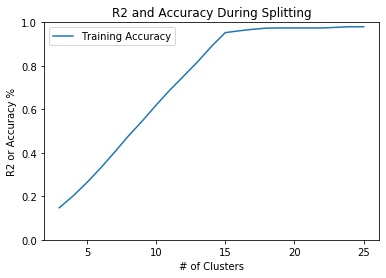

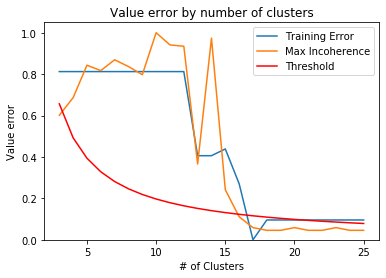

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 110  completed
Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.917504  -0.359175      2 -0.004           0        0   
1       0     1   1.469175  -0.730709      2 -0.004           1        0   
2       0     2   2.663953  -0.227007      1 -0.004           2        0   
3       0     3   2.141935  -1.350262      1 -0.004           7        0   
4       0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
2990  129    20   4.465467  -0.049625      1 -0.004           4        0   
2991  129    21   4.478048  -1.821326      1 -0.004           9        0   
2992  129    22   4.475488  -2.665928      1 -0.004          14        0   
2993  129    23   4.971379  -3.981543      1 -0.004          19        0   
2994  129    24   4.845846  -4.536592   None  1.000          24        1   

     NEXT_CLUSTER  
0               0  
1       

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:02<00:47,  2.14s/it]

threshold 109.45318634009702 max_inc 102.00000000000006
new opt_k 3


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:04<00:45,  2.14s/it]

threshold 82.08988975507276 max_inc 114.99999999999996


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:06<00:44,  2.21s/it]

threshold 65.67191180405821 max_inc 142.99999999999997


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:08<00:41,  2.17s/it]

threshold 54.72659317004851 max_inc 141.99999999999997


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:10<00:39,  2.17s/it]

threshold 46.908508431470146 max_inc 151.99999999999997


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:13<00:37,  2.23s/it]

threshold 41.04494487753638 max_inc 152.00000000000006


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:15<00:36,  2.30s/it]

threshold 36.484395446699004 max_inc 145.0


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:18<00:34,  2.30s/it]

threshold 32.835955902029106 max_inc 181.0


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:20<00:31,  2.28s/it]

threshold 29.85086900184464 max_inc 172.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:22<00:29,  2.30s/it]

threshold 27.363296585024255 max_inc 171.99999999999997


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:25<00:28,  2.34s/it]

threshold 25.258427616945465 max_inc 68.00000000000003


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:27<00:26,  2.41s/it]

threshold 23.454254215735073 max_inc 177.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:30<00:25,  2.51s/it]

threshold 21.890637268019404 max_inc 40.0


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:33<00:23,  2.58s/it]

threshold 20.52247243876819 max_inc 19.0
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:35<00:21,  2.65s/it]

threshold 19.31526817766418 max_inc 6.999999999999999
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:38<00:18,  2.66s/it]

threshold 18.242197723349502 max_inc 6.999999999999999
new opt_k 18


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:41<00:15,  2.62s/it]

threshold 17.28208205369953 max_inc 5.999999999999998


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:43<00:12,  2.59s/it]

threshold 16.417977951014553 max_inc 19.0


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:46<00:10,  2.60s/it]

threshold 15.636169477156717 max_inc 10.000000000000004


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:48<00:07,  2.61s/it]

threshold 14.92543450092232 max_inc 8.999999999999996


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [00:51<00:05,  2.62s/it]

threshold 14.27650256609961 max_inc 33.99999999999999


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:54<00:02,  2.63s/it]

threshold 13.681648292512127 max_inc 20.000000000000007


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [00:59<00:02,  2.70s/it]

threshold 13.134382360811642 max_inc 23.000000000000007
Optimal # of clusters reached


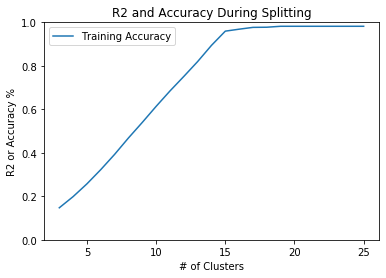

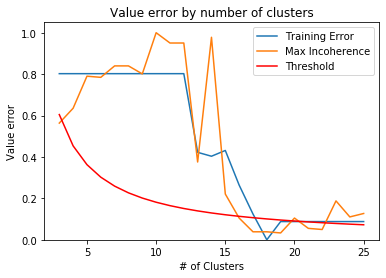

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning
Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

N= 130  completed
Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.917504  -0.359175      2 -0.004           0        0   
1       0     1   1.469175  -0.730709      2 -0.004           1        0   
2       0     2   2.663953  -0.227007      1 -0.004           2        0   
3       0     3   2.141935  -1.350262      1 -0.004           7        0   
4       0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
3450  149    17   4.247180  -3.303244      2 -0.004          19        0   
3451  149    18   4.973199  -3.877044      0 -0.004          19        0   
3452  149    19   4.901420  -2.019491      1 -0.004          14        0   
3453  149    20   4.985010  -3.259465      1 -0.004          19        0   
3454  149    21   4.566696  -4.885857   None  1.000          24        1   

     NEXT_CLUSTER  
0               0  
1       

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:02<00:50,  2.28s/it]

threshold 117.55849607748478 max_inc 121.00000000000003


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:04<00:47,  2.28s/it]

threshold 88.16887205811358 max_inc 132.00000000000003


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:07<00:49,  2.48s/it]

threshold 70.53509764649087 max_inc 162.00000000000003


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:11<00:55,  2.93s/it]

threshold 58.77924803874239 max_inc 162.0


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:14<00:51,  2.84s/it]

threshold 50.38221260463633 max_inc 170.00000000000006


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:16<00:46,  2.74s/it]

threshold 44.08443602905679 max_inc 173.0


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:19<00:42,  2.68s/it]

threshold 39.18616535916159 max_inc 169.99999999999994


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:21<00:39,  2.63s/it]

threshold 35.267548823245434 max_inc 208.0


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:24<00:36,  2.59s/it]

threshold 32.06140802113221 max_inc 201.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:26<00:33,  2.61s/it]

threshold 29.389624019371194 max_inc 201.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:30<00:34,  2.84s/it]

threshold 27.128883710188795 max_inc 77.99999999999999


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:33<00:31,  2.86s/it]

threshold 25.191106302318165 max_inc 207.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:36<00:29,  2.91s/it]

threshold 23.511699215496954 max_inc 50.00000000000001


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:39<00:27,  3.06s/it]

threshold 22.042218014528395 max_inc 20.000000000000004
new opt_k 16


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:42<00:24,  3.08s/it]

threshold 20.745616954850252 max_inc 9.999999999999998
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:45<00:21,  3.07s/it]

threshold 19.593082679580796 max_inc 5.999999999999998


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:48<00:18,  3.08s/it]

threshold 18.56186780170812 max_inc 5.999999999999997
new opt_k 19


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:52<00:16,  3.23s/it]

threshold 17.633774411622717 max_inc 57.99999999999999


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [00:56<00:13,  3.36s/it]

threshold 16.79407086821211 max_inc 22.0


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [00:59<00:10,  3.36s/it]

threshold 16.030704010566105 max_inc 20.0


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [01:03<00:06,  3.46s/it]

threshold 15.333716879671927 max_inc 58.99999999999999


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:06<00:03,  3.54s/it]

threshold 14.694812009685597 max_inc 43.0


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:10<00:03,  3.23s/it]

threshold 14.107019529298173 max_inc 25.0
Optimal # of clusters reached


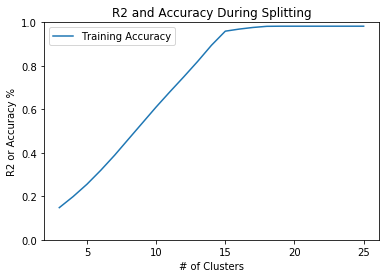

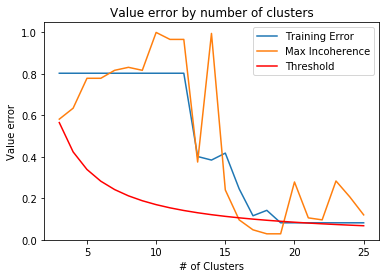

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


N= 150  completed


Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.917504  -0.359175      2 -0.004           0        0   
1       0     1   1.469175  -0.730709      2 -0.004           1        0   
2       0     2   2.663953  -0.227007      1 -0.004           2        0   
3       0     3   2.141935  -1.350262      1 -0.004           7        0   
4       0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
3898  169    20   3.628847  -1.622387      2 -0.004           8        0   
3899  169    21   4.531689  -1.545099      0 -0.004           9        0   
3900  169    22   4.631988  -0.679713      1 -0.004           4        0   
3901  169    23   4.732682  -1.504164      0 -0.004           9        0   
3902  169    24   4.848533  -0.029589      0 -0.004           4        0   

     NEXT_CLUSTER  
0               0  
1               0  
2     

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:02<01:03,  2.87s/it]

threshold 124.94798917949821 max_inc 138.0


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:05<01:01,  2.91s/it]

threshold 93.71099188462365 max_inc 148.00000000000003


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:08<00:57,  2.90s/it]

threshold 74.96879350769892 max_inc 185.99999999999994


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:11<00:53,  2.84s/it]

threshold 62.473994589749104 max_inc 182.99999999999994


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:14<00:52,  2.91s/it]

threshold 53.54913821978494 max_inc 191.99999999999997


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:17<00:49,  2.92s/it]

threshold 46.855495942311826 max_inc 195.0


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:20<00:47,  2.95s/it]

threshold 41.6493297264994 max_inc 191.0


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:23<00:44,  2.95s/it]

threshold 37.48439675384946 max_inc 236.00000000000003


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:26<00:41,  2.93s/it]

threshold 34.076724321681326 max_inc 226.99999999999997


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:29<00:38,  2.99s/it]

threshold 31.236997294874552 max_inc 230.00000000000003


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:32<00:36,  3.02s/it]

threshold 28.83415134911497 max_inc 86.0


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:36<00:36,  3.34s/it]

threshold 26.77456910989247 max_inc 235.0


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:40<00:33,  3.37s/it]

threshold 24.98959783589964 max_inc 55.999999999999986


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:43<00:29,  3.29s/it]

threshold 23.427747971155913 max_inc 25.000000000000007


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:46<00:26,  3.25s/it]

threshold 22.04964514932321 max_inc 21.0
new opt_k 17


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:49<00:23,  3.32s/it]

threshold 20.8246648632497 max_inc 11.000000000000002


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [00:54<00:21,  3.61s/it]

threshold 19.728629870447083 max_inc 11.000000000000002


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [00:58<00:19,  3.83s/it]

threshold 18.74219837692473 max_inc 12.000000000000007


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [01:01<00:14,  3.65s/it]

threshold 17.849712739928314 max_inc 12.000000000000007


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [01:04<00:10,  3.52s/it]

threshold 17.038362160840663 max_inc 16.000000000000004


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [01:09<00:07,  3.71s/it]

threshold 16.297563806021504 max_inc 12.000000000000007


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:12<00:03,  3.66s/it]

threshold 15.618498647437276 max_inc 12.000000000000007
new opt_k 24


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:16<00:03,  3.46s/it]

threshold 14.993758701539784 max_inc 9.0
Optimal # of clusters reached


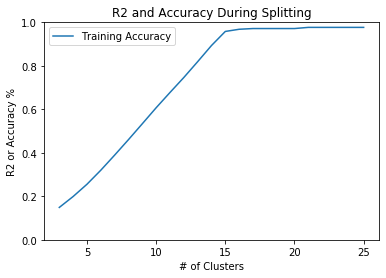

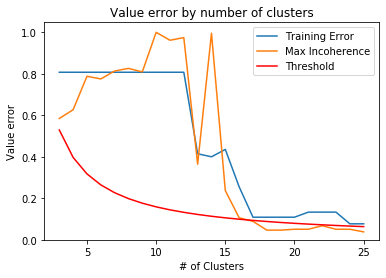

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


N= 170  completed


Splitting... |#Clusters:2:   0%|          | 0/23 [00:00<?, ?it/s]

Clusters Initialized
       ID  TIME  FEATURE_0  FEATURE_1 ACTION   RISK  OG_CLUSTER  CLUSTER  \
0       0     0   0.917504  -0.359175      2 -0.004           0        0   
1       0     1   1.469175  -0.730709      2 -0.004           1        0   
2       0     2   2.663953  -0.227007      1 -0.004           2        0   
3       0     3   2.141935  -1.350262      1 -0.004           7        0   
4       0     4   2.644228  -2.347577      0 -0.004          12        0   
...   ...   ...        ...        ...    ...    ...         ...      ...   
4568  199    14   3.757846  -1.040545      2 -0.004           8        0   
4569  199    15   4.219758  -1.602285      1 -0.004           9        0   
4570  199    16   4.444872  -2.464416      1 -0.004          14        0   
4571  199    17   4.219659  -3.406585      1 -0.004          19        0   
4572  199    18   4.291367  -4.459939   None  1.000          24        1   

     NEXT_CLUSTER  
0               0  
1               0  
2     

Splitting... |#Clusters:3:   4%|▍         | 1/23 [00:03<01:12,  3.30s/it]

threshold 135.2479205015737 max_inc 163.0


Splitting... |#Clusters:4:   9%|▊         | 2/23 [00:06<01:08,  3.28s/it]

threshold 101.43594037618027 max_inc 171.0


Splitting... |#Clusters:5:  13%|█▎        | 3/23 [00:09<01:04,  3.25s/it]

threshold 81.14875230094421 max_inc 214.0


Splitting... |#Clusters:6:  17%|█▋        | 4/23 [00:13<01:02,  3.28s/it]

threshold 67.62396025078685 max_inc 213.0


Splitting... |#Clusters:7:  22%|██▏       | 5/23 [00:16<01:00,  3.34s/it]

threshold 57.96339450067444 max_inc 224.00000000000003


Splitting... |#Clusters:8:  26%|██▌       | 6/23 [00:19<00:56,  3.35s/it]

threshold 50.717970188090135 max_inc 224.99999999999991


Splitting... |#Clusters:9:  30%|███       | 7/23 [00:23<00:53,  3.35s/it]

threshold 45.08264016719123 max_inc 225.00000000000003


Splitting... |#Clusters:10:  35%|███▍      | 8/23 [00:27<00:52,  3.48s/it]

threshold 40.574376150472105 max_inc 278.0000000000001


Splitting... |#Clusters:11:  39%|███▉      | 9/23 [00:31<00:51,  3.70s/it]

threshold 36.88579650042919 max_inc 266.0


Splitting... |#Clusters:12:  43%|████▎     | 10/23 [00:34<00:46,  3.61s/it]

threshold 33.811980125393426 max_inc 276.0


Splitting... |#Clusters:13:  48%|████▊     | 11/23 [00:38<00:42,  3.55s/it]

threshold 31.211058577286238 max_inc 100.00000000000003


Splitting... |#Clusters:14:  52%|█████▏    | 12/23 [00:41<00:39,  3.55s/it]

threshold 28.98169725033722 max_inc 280.00000000000006


Splitting... |#Clusters:15:  57%|█████▋    | 13/23 [00:45<00:36,  3.61s/it]

threshold 27.04958410031474 max_inc 50.999999999999986


Splitting... |#Clusters:16:  61%|██████    | 14/23 [00:49<00:33,  3.71s/it]

threshold 25.358985094045067 max_inc 27.000000000000004


Splitting... |#Clusters:17:  65%|██████▌   | 15/23 [00:53<00:30,  3.77s/it]

threshold 23.867280088513006 max_inc 29.0


Splitting... |#Clusters:18:  70%|██████▉   | 16/23 [00:57<00:26,  3.77s/it]

threshold 22.541320083595615 max_inc 16.00000000000001
new opt_k 18


Splitting... |#Clusters:19:  74%|███████▍  | 17/23 [01:00<00:22,  3.80s/it]

threshold 21.35493481603795 max_inc 12.999999999999998


Splitting... |#Clusters:20:  78%|███████▊  | 18/23 [01:04<00:19,  3.82s/it]

threshold 20.287188075236052 max_inc 17.999999999999993


Splitting... |#Clusters:21:  83%|████████▎ | 19/23 [01:08<00:15,  3.82s/it]

threshold 19.321131500224812 max_inc 12.999999999999998


Splitting... |#Clusters:22:  87%|████████▋ | 20/23 [01:12<00:11,  3.85s/it]

threshold 18.442898250214594 max_inc 12.999999999999998
new opt_k 22


Splitting... |#Clusters:23:  91%|█████████▏| 21/23 [01:16<00:07,  3.87s/it]

threshold 17.641033108900917 max_inc 12.999999999999998


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:21<00:04,  4.13s/it]

threshold 16.905990062696713 max_inc 16.999999999999993


Splitting... |#Clusters:24:  96%|█████████▌| 22/23 [01:25<00:03,  3.90s/it]

threshold 16.229750460188843 max_inc 13.999999999999996
Optimal # of clusters reached


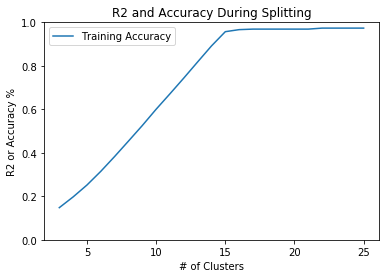

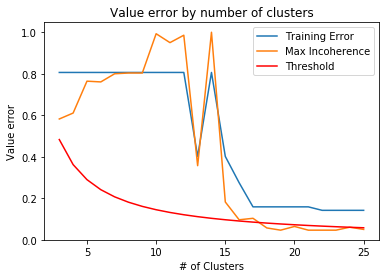

N= 200  completed


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [5]:
# Setting parameters for model fitting
max_k = 25
classification = 'DecisionTreeClassifier'
split_classifier_params = {'random_state':0, 'max_depth':2}
clustering = 'Agglomerative'
n_clusters = None
distance_threshold = 0.5
random_state = 0
pfeatures = 2
gamma = 1
actions = [0, 1, 2, 3]
h = -1
cv = 5
th = 0
eta = 6 

Ns = [10, 20, 30, 40, 50, 70, 90, 110, 130, 150, 170, 200]
df_full = df.copy()

models=[]
    
# Training models 
for n in Ns:
    df_small = df_full.loc[df_full['ID']<n]
    
    m = MDP_model()
    m.fit(df_small, # df: dataframe in the format ['ID', 'TIME', ...features..., 'RISK', 'ACTION']
        pfeatures, # int: number of features
        h, # int: time horizon (# of actions we want to optimize)
        gamma, # discount factor
        max_k, # int: number of iterations
        distance_threshold, # clustering diameter for Agglomerative clustering
        cv, # number for cross validation
        th, # splitting threshold
        eta, # incoherence threshold
        classification, # classification method
        split_classifier_params, # classification params
        clustering,# clustering method from Agglomerative, KMeans, and Birch
        n_clusters, # number of clusters for KMeans
        random_state,
        plot=True,
        optimize=True)
    print('N=', n, ' completed')
    models.append(m)

### Errors

Now, we are going to evaluate how the various models have performed in terms of their in-sample training error (at the point where the model has reached the optimal clustering and stopped training), as well as the out-of-sample testing error based on a newly generated dataset with the same parameters.

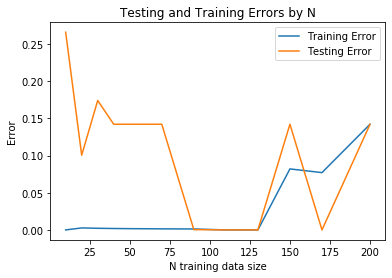

In [11]:
from testing import testing_value_error

N = 100
T_max = 25
r = 0.4
maze = mazes[4]
# Creating a test set with same parameters as training set
df_test = createSamples(N, T_max, maze, r, reseed=True)

# In & out sample training and testing value errors: 
training_errors = []
testing_errors = []
for m in models: 
    tr_err = m.training_error.loc[m.training_error['Clusters']==m.opt_k]['Error'].min()
    te_err = testing_value_error(df_test, m.df_trained, m.m, m.pfeatures, gamma, relative=False, h=-1)
    training_errors.append(tr_err)
    testing_errors.append(te_err)

fig1, ax1 = plt.subplots()
ax1.plot(Ns, training_errors, label='Training Error')
ax1.plot(Ns, testing_errors, label='Testing Error')
ax1.set_title('Testing and Training Errors by N')
ax1.set_xlabel('N training data size')
ax1.set_ylabel('Error')
ax1.legend()

### Accuracies

We also want to measure both training and testing accuracies, measured as how well the model learns and maps each point to the correct original clustering of the maze, and how these values change as data size increases. 

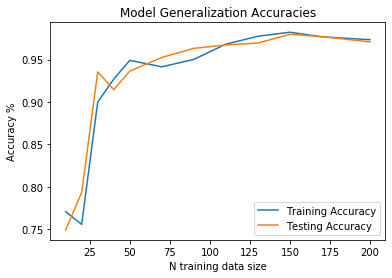

In [12]:
from testing import generalization_accuracy

tr_acc, test_acc = generalization_accuracy(models, df_test, Ns)

### Optimality Gap

Next, we want to measure the optimality gap, where given a point that begins randomly in the starting cell, we want to measure the value difference after `t_max` steps between two scenarios: 1) if this point takes only the optimal action through the maze, and 2) if this point takes the action that the model prescribes based on the model's solved MDP. In both scenarios, the point progresses through the maze according to the actual maze dynamics; the only difference lies in what sequence of actions it is given.


We will once again plot the change in this value as data size increases.

Optimal Value: [1.97918642e-01 2.24354046e-01 2.53726718e-01 5.74109600e-01
 6.42344000e-01 1.33442690e-01 1.97918642e-01 2.86363020e-01
 6.42344000e-01 7.18160000e-01 1.52714100e-01 1.74126778e-01
 3.22625578e-01 5.74109600e-01 8.02400000e-01 2.86363020e-01
 3.22625578e-01 3.62917309e-01 5.12698640e-01 8.96000000e-01
 2.53726718e-01 3.62917309e-01 4.07685899e-01 4.57428776e-01
 1.00000000e+00 1.61397581e-10]
Optimal Policy: [2 2 1 2 1 1 0 1 2 1 2 0 1 0 1 2 1 1 0 1 0 2 2 0 0 0]
Round N= 10
Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  8.31806849e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 0 0]


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Round N= 20


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  8.31806849e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 0 0]
Round N= 30


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01 -9.00004000e+02
 -9.00004000e+02  4.91173626e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 0 0 0 0]
Round N= 40


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01 -9.00004000e+02  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01  3.62917309e-01
  6.42344000e-01  6.06387193e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 0 0 0 0 2 1 1 1 2 2 2 2 0 0]
Round N= 50


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01 -9.00004000e+02  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01 -9.00004000e+02
  6.42344000e-01  4.91173626e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 0 0 0 0 2 1 1 1 2 2 0 2 0 0]
Round N= 70


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01 -9.00004000e+02  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01  3.62917309e-01
  6.42344000e-01  6.06387193e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 0 0 0 0 2 1 1 1 2 2 2 2 0 0]
Round N= 90


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01 -9.00004000e+02  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  2.24354046e-01  1.97918642e-01  6.42344000e-01
 -9.00004000e+02  4.91173626e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 0 0 0 0 2 1 1 1 2 2 2 0 0 0]
Round N= 110


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  2.24354046e-01  1.97918642e-01  3.62917309e-01
 -9.00004000e+02  6.06387193e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0]
Round N= 130


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  2.24354046e-01  1.97918642e-01  3.62917309e-01
 -9.00004000e+02 -9.00004000e+02  4.91173626e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0 0]
Round N= 150


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  2.24354046e-01  1.97918642e-01  3.62917309e-01
 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02  4.42056264e-13
 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0 0 0]
Round N= 170


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  2.24354046e-01  1.97918642e-01  3.62917309e-01
 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02
 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02
  2.90033115e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0]
Round N= 200


/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:46: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:3072: RuntimeWarning: invalid value encountered in greater_equal
  cond1 = (k >= _a) & (k < _b)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:357: RuntimeWarning: invalid value encountered in less_equal
  beta))<=alpha]
/Users/janiceyang/Dropbox (MIT)/ORC UROP/Opioids/Algorithm/model.py:387: RuntimeWarning: invalid value encountered in greater
  beta))>alpha]


Optimal Value: [ 2.53726718e-01  1.00000000e+00  8.96000000e-01  8.02400000e-01
  7.18160000e-01  6.42344000e-01  5.74109600e-01  5.12698640e-01
  4.57428776e-01  4.07685898e-01  3.62917309e-01  3.22625578e-01
  2.86363020e-01  1.97918642e-01  2.24354046e-01  3.62917309e-01
 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02 -9.00004000e+02
 -9.00004000e+02 -9.00004000e+02  3.22259016e-13 -1.00000000e+03]
Optimal Policy: [1 0 1 1 1 2 0 0 0 2 1 1 1 2 2 2 0 0 0 0 0 0 0 0]


Text(0, 0.5, '|V_alg-V*|')

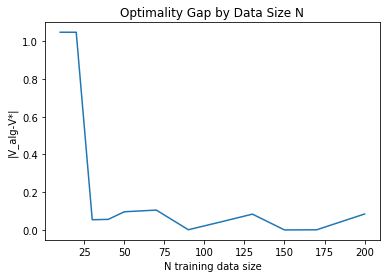

In [16]:
from maze_functions import get_maze_MDP, get_maze_transition_reward, value_diff

# Set Parameters
P, R = get_maze_MDP(maze)
K = 100
f, rw = get_maze_transition_reward(maze)

opt_gap = value_diff(models, Ns, K, T_max, P, R, f, rw)
fig1, ax1 = plt.subplots()
ax1.plot(Ns, opt_gap)
ax1.set_title('Optimality Gap by Data Size N')
ax1.set_xlabel('N training data size')
ax1.set_ylabel('|V_alg-V*|')